## Image segmentation 

This notebook implements a simple image segmentation model. The picture examples are microscope images of tissue samples 
and the segmentation masks mark the cell nucleus. The images are from Kaggle 2018 Data Science Bowl competition dataset. 

The same model works for different kinds of semantic segmentation tasks. The model takes about 420 MB disk space and the model contains approx 35M trainable parameters. 

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import random, threading, cv2, keras
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.models import load_model

from IPython.display import clear_output

In [2]:
# Global variables
img_size = (512, 512)  # image size (x, y)
val_split = 0.1 # Amount of images to use for model validation
model_filename = "segmentation_model_v1.h5"

# Notebook settings
%matplotlib inline

## Load image arrays for training

* The images and masks have been preprocessed and saved to numpy arrays. All have resolution 512 x 512 x 1 and there are 546 mask & image pairs.
* The images have been preprocessed to grayscale color with values in [0, 1] range. 
* The mask images have been defined as 0 = background, 1 = foreground. 
* The array shape is (image_id, image_rows, image_columns, image_color_channel), which works directly with Keras models.

In [3]:
img_array = np.load("train_images.npy")
mask_array = np.load("train_masks.npy")

print(img_array.shape)
print(mask_array.shape)

(546, 512, 512, 1)
(546, 512, 512, 1)


## Training sequence generators and image augmentation
The model training uses data generators for training images and training masks. It enables data augmentation during the training without exploding the training data memory consumption. 

In [28]:
class BatchIndices(object):
    def __init__(self, n, bs, shuffle=False):
        self.n, self.bs, self.shuffle = n, bs, shuffle
        self.lock = threading.Lock()
        self.reset()

    def reset(self):
        self.idxs = (np.random.permutation(self.n) 
                     if self.shuffle else np.arange(0, self.n))
        self.curr = 0

    def __next__(self):
        with self.lock:
            if self.curr >= self.n: self.reset()
            ni = min(self.bs, self.n-self.curr)
            res = self.idxs[self.curr:self.curr+ni]
            self.curr += ni
            return res

class DataGenerator(object):
    def __init__(self, x_arr, y_arr, batch_size=32, train=True):
        self.x_array = x_arr # images
        self.y_array = y_arr # targets
        self.batch_size = batch_size
        self.train = train # train vs. test flag
        self.n_img = x_arr.shape[0] # image quantity
        self.idx_gen = BatchIndices(self.n_img, self.batch_size, self.train)
        
    def get_item(self, idx):
        x = self.x_array[idx].copy().astype(np.float32)
        y = self.y_array[idx].copy()
        
        # Randomly flip vertically
        if self.train and (random.random() > 0.5): 
            y = np.flip(y, axis=0)
            x = np.flip(x, axis=0)
            
        # Randomly flip horizontally
        if self.train and (random.random() > 0.5): 
            y = np.flip(y, axis=1)
            x = np.flip(x, axis=1)
        return x, y

    def __next__(self):
        idxs = next(self.idx_gen)
        items = (self.get_item(idx) for idx in idxs)
        xs, ys = zip(*items)
        return np.stack(xs), np.stack(ys)


In [29]:

# Training batch size is defined here. 
batch_size = 4

img_qty = img_array.shape[0]
train_indexes = np.full((img_qty), True) 
tmp = np.random.choice(img_qty, int(img_qty * val_split), replace=False)
train_indexes[tmp] = False

train_img = img_array[train_indexes==True]
train_label = mask_array[train_indexes==True]

test_img = img_array[train_indexes==False]
test_label = mask_array[train_indexes==False]

n_train = int(train_img.shape[0] / batch_size)
n_test = int(test_img.shape[0] / batch_size)

train_gen = DataGenerator(train_img, train_label, batch_size, train=True)
test_gen = DataGenerator(test_img, test_label, batch_size, train=False)

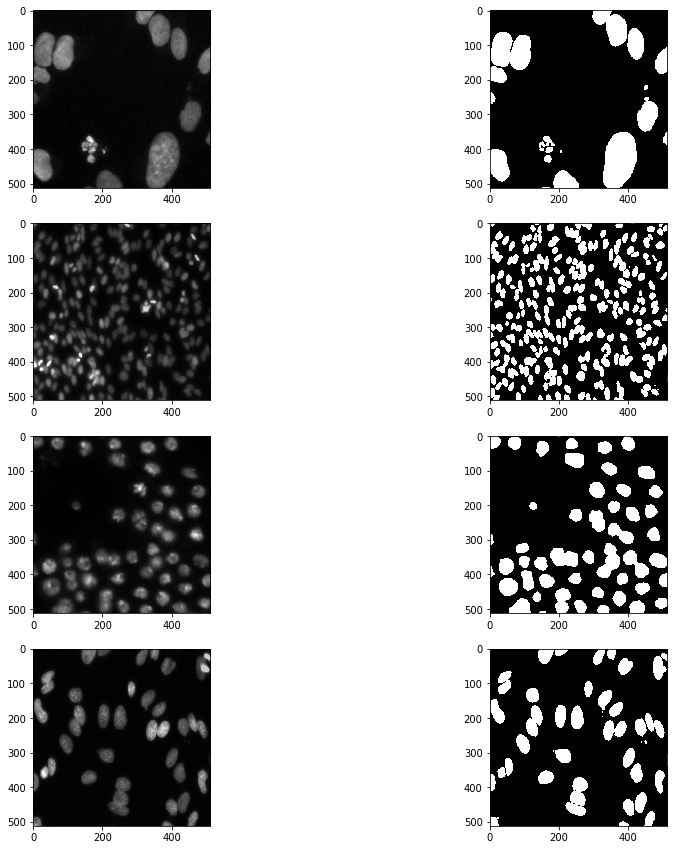

In [37]:
# Test the sequence generator
image, mask = train_gen.__next__()

f, axarr = plt.subplots(4,2, figsize=(15,15))
axarr[0][0].imshow(image[0, :, :, 0], cmap='gray')
axarr[0][1].imshow(mask[0, :, :, 0], cmap='gray')
axarr[1][0].imshow(image[1, :, :, 0], cmap='gray')
axarr[1][1].imshow(mask[1, :, :, 0], cmap='gray')
axarr[2][0].imshow(image[2, :, :, 0], cmap='gray')
axarr[2][1].imshow(mask[2, :, :, 0], cmap='gray')
axarr[3][0].imshow(image[3, :, :, 0], cmap='gray')
axarr[3][1].imshow(mask[3, :, :, 0], cmap='gray')
plt.show()

# The images on the left are the input images to the model. 
# The images on the right are the masks that are used as the model training target. 

## The model 
This model is architecturally similar to U-net and One Hundred Layer Tiramisu models. Good features have been adopted from 
both of those models. 
There was few guiding principles in developing this model: 
* It must have good spatial accuracy in the segmentation prediction. This is accomplished by passing the input array towards the model output through the skip connections and also by concatenating it with the convolutional layer outputs at the next convolutional layer input. 
* There are more maxpooling layers than in the original U-net in order to get largert 'field of view' to the convolutional layers. In some cases this is not needed and the layer amount can be reduced. The same could be achieved using dilated convolutions, but it didn't produce the necessary accuracy in this use case. 
* I wanted to keep the model size 'small' so that at least batch size of 2 is possible on single GFX1080TI. This forced the use of upsampling layers in the up_blocks instead of conv2dtranspose. The conv2dtranspose would improve accuracy, but the parameter count and model memory footpriont would explode. 
* The model must be fast to train. Typically there are very few training images available, so it must be possible to train the model with just few tens of images without compromising the model ability to generalize the learnings. The Tiramisu model does exactly that, which is the reason I reused some of the ideas in this model. 

In [7]:

def down_block(inputs, n_filters):
    layer_1 = Conv2D(n_filters, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    layer_2 = concatenate([layer_1, inputs], axis=-1)
    layer_3 = Conv2D(n_filters, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(layer_2)
    layer_4 = concatenate([layer_3, layer_1, inputs], axis=-1)
    layer_5 = Conv2D(n_filters, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(layer_4)
    layer_6 = BatchNormalization(axis=-1)(layer_5)
    layer_7 = MaxPooling2D(pool_size=(2, 2))(layer_6)
    layer_8 = Dropout(0.1)(layer_7)
    skip = concatenate([layer_6, inputs], axis=-1)
    return skip, layer_8
    
def bottom_block(inputs, n_filters):
    drop_rate = 0.1
    layer_1 = Conv2D(n_filters, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    layer_2 = concatenate([layer_1, inputs], axis=-1)
    layer_3 = Conv2D(n_filters, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(layer_2)
    layer_4 = concatenate([layer_3, layer_1, inputs], axis=-1)
    layer_5 = Conv2D(n_filters, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(layer_4)
    layer_6 = BatchNormalization(axis=-1)(layer_5)
    layer_7 = Dropout(0.1)(layer_6)
    return layer_7

def up_block(skip_input, ups_input, n_filters, no_dropout=False):
    layer_1 = UpSampling2D(size=(2, 2))(ups_input)
    layer_2 = concatenate([layer_1, skip_input], axis=-1)
    layer_3 = Conv2D(n_filters, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(layer_2)
    layer_4 = concatenate([layer_3, layer_2], axis=-1)
    layer_5 = Conv2D(n_filters, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(layer_4)
    layer_6 = concatenate([layer_5, layer_3, layer_2], axis=-1)
    layer_7 = Conv2D(n_filters, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_normal')(layer_6)
    layer_8 = BatchNormalization(axis=-1)(layer_7)    
    if no_dropout:
        layer_9 = layer_8
    else:
        layer_9 = Dropout(0.1)(layer_8)
    return layer_9
    
def get_model():
    inputs = Input(img_size + (1,)) 
    skip1, down1 = down_block(inputs, 16) 
    skip2, down2 = down_block(down1, 32) 
    skip3, down3 = down_block(down2, 64) 
    skip4, down4 = down_block(down3, 128) 
    skip5, down5 = down_block(down4, 256) 
    skip6, down6 = down_block(down5, 256) 
    bottom = bottom_block(down6, 512)
    up_1 = up_block(skip6, bottom, 256)
    up_2 = up_block(skip5, up_1, 256)
    up_3 = up_block(skip4, up_2, 128)
    up_4 = up_block(skip3, up_3, 64)
    up_5 = up_block(skip2, up_4, 32)
    up_6 = up_block(skip1, up_5, 16, no_dropout=True)
    outputs = Conv2D(1, 1, activation = 'sigmoid')(up_6)

    model = Model(inputs, outputs)
    model.compile(optimizer = Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Training callbacks

In [8]:
def lr_calculator(epoch, lr=None):
    lr_baseline = 0.00001
    
    # Adjustable parameters for cyclic mode:
    cyclic = True  # Set True to enable cyclic mode. 
    lr_start_min = 0.0005
    lr_start_max = 0.002
    lr_ramp_steps = 10
    lr_decay_per_cycle = .96
    
    # Decaying smooth lr mode:
    lr_start = 0.001
    lr_decay_per_epoch = 0.99

    # lr calculation
    if cyclic: 
        step_size = (lr_start_max - lr_start_min) / lr_ramp_steps
        cycle = int(epoch / (2 * lr_ramp_steps))
        cycle_phase = int(epoch / lr_ramp_steps) % 2
        cycle_step = epoch % lr_ramp_steps

        if cycle_phase == 1: # Falling phase
            new_lr = lr_start_max - step_size * cycle_step
        else: # Rising phase
            new_lr = lr_start_min + step_size * cycle_step        
        new_lr *= (lr_decay_per_cycle ** epoch)
        new_lr += lr_baseline
        
    else: # not cyclic mode
        new_lr = lr_baseline + lr_start * (lr_decay_per_epoch ** epoch)

    return new_lr

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.accs = []
        self.val_accs = []   
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('acc'))
        self.val_accs.append(logs.get('val_acc'))
        self.plot_losses()
        
    def get_losses(self):
        return self.losses, self.val_losses
    
    def plot_losses(self):
        # This plots the loss history to a live plot in the training window.
        clear_output(wait=True)
        plt.figure(figsize=(10,8))
        plt.title('Losses')
        plt.xlabel('epoch')
        plt.plot(self.losses, label='loss')
        plt.plot(self.val_losses, label='val_loss')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()
        
        plt.figure(figsize=(10,8))
        plt.title('Accuracy')
        plt.xlabel('epoch')
        plt.plot(self.accs, label='acc')
        plt.plot(self.val_accs, label='val_acc')
        plt.legend(loc='best')
        plt.grid(True)
        plt.show()
        
model_lr = LearningRateScheduler(lr_calculator, verbose=0)
model_losses = LossHistory()
model_checkpoint = ModelCheckpoint(model_filename, monitor='val_loss', verbose=1, save_best_only=True)

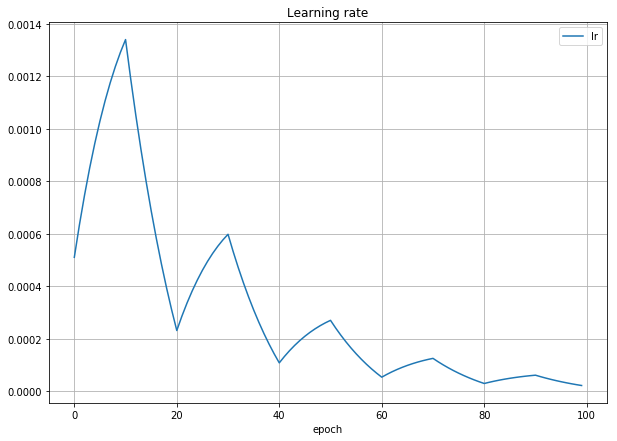

In [9]:
# Plot learning rate curve

lr = [lr_calculator(x) for x in range(100)]
plt.figure(figsize=(10,7))
plt.title('Learning rate')
plt.xlabel('epoch')
plt.plot(lr, label='lr')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [11]:
model = get_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 512, 512, 17) 0           conv2d_1[0][0]                   
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 16) 2464        concatenate_1[0][0]              
__________

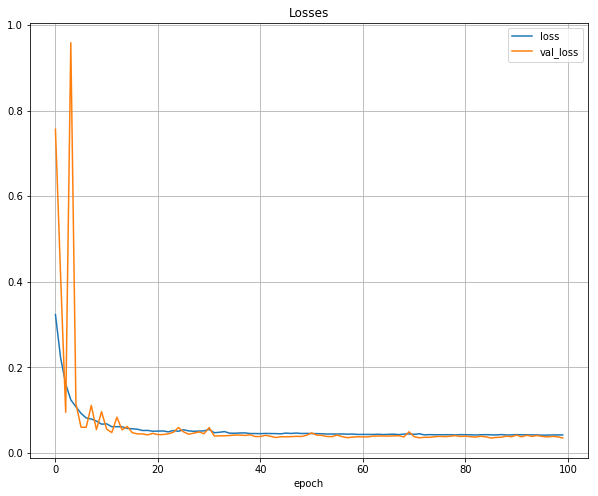

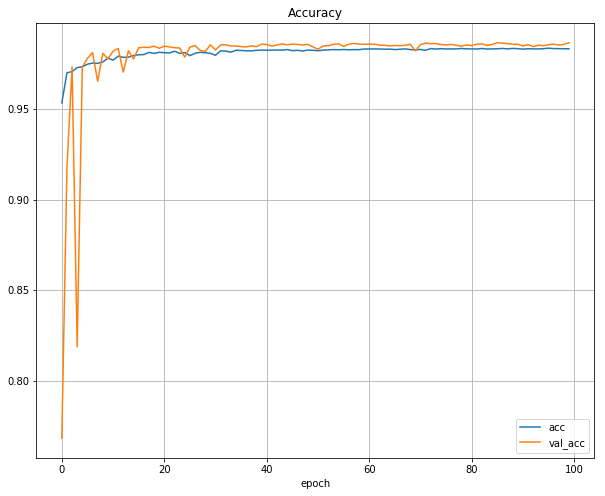


Epoch 00100: val_loss did not improve
123/123 [==============================] - 54s 438ms/step - loss: 0.0424 - acc: 0.9832 - val_loss: 0.0353 - val_acc: 0.9866


In [12]:
# Training 
model.fit_generator(generator=train_gen, steps_per_epoch=n_train, epochs=100, 
                    verbose=1, callbacks=[model_losses, model_lr, model_checkpoint], 
                   validation_data=test_gen, validation_steps=n_test, shuffle=False )

## Check some predictions

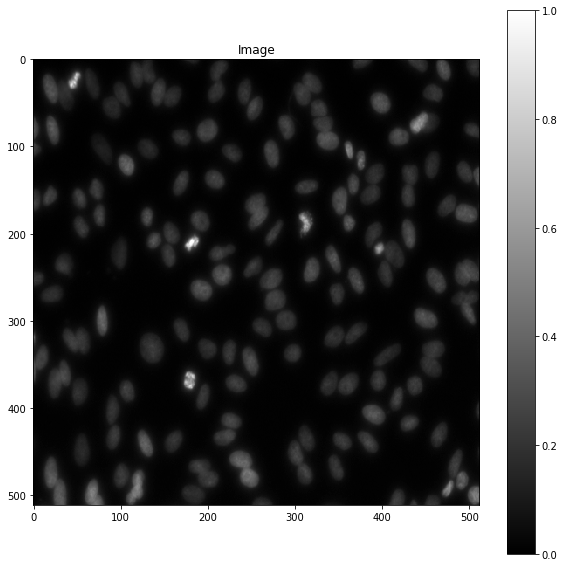

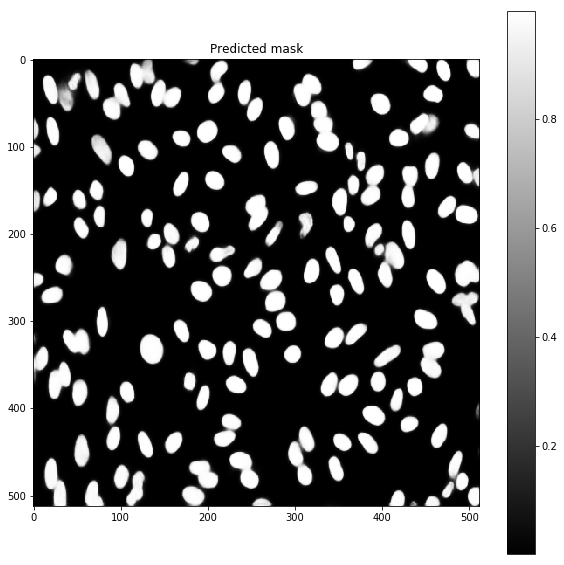

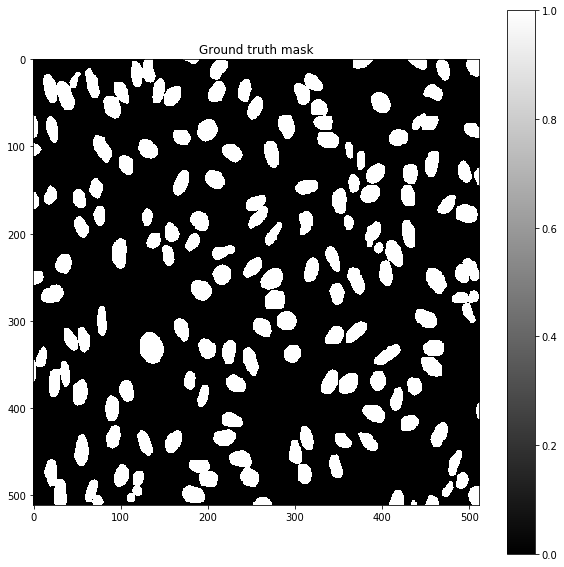

In [80]:
img_index = 120

# Get the predictions
predicted_mask = model.predict(np.expand_dims(img_array[img_index], axis=0), verbose=0)

# Plot the image
plt.figure(figsize=(10,10))
plt.imshow(img_array[img_index, :, :, 0], cmap='gray')
plt.title('Image')
plt.colorbar()
plt.show()

# Plot the model output
plt.figure(figsize=(10,10))
plt.imshow(predicted_mask[0, :, :, 0], cmap='gray')
plt.title('Predicted mask')
plt.colorbar()
plt.show()

# Plot the training mask 
plt.figure(figsize=(10,10))
plt.imshow(mask_array[img_index, :, :, 0], cmap='gray')
plt.title('Ground truth mask')
plt.colorbar()
plt.show()